# Table of Content
* [Goal](#Goal)
* [Wrangle](#Wrangle)
* [Explore Data Analysis](#Explore)
  * [Overall Top 20](#Over-All-Top-20-Words)
  * [Each Langauge's Top 10 Words](#Top-10-Words-from-Javascript-and-Python)
* [Models](#Model)
* [Conclusion](#Conclusion)

In [50]:
# establishing environment
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prepare import prep_gitMDs
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

print('Initalized')

Initalized


# Goal
The goal of this project is to use Natural Language Processing (NLP) to predict the primary coding language of a gitrepo using the repo's README.  

We will also deliver the following:

  * A Jupyter notebook containing detailing to every step of this project
  * A 5-minute presentation about the project, including slides

# Wrangle
We will use the modules ***[prepare.py](https://github.com/NLP-MVPs/nlp-project/blob/main/prepare.py)*** to gather the data, clean the data, and put it into a dataframe. From there we will begin to wrangle the data for exploration focusining mainly on creating word strings and additional dataframe from our data.

[Table of Content](#Table-of-Content)

In [2]:
help(prep_gitMDs)

Help on function prep_gitMDs in module prepare:

prep_gitMDs()
    Uses the helper functions contained within the prepare.py module on the gitMDs repo url list from the acquire.py module to create a unified data frame for exploration
    * Applies a basic_body_clean, tokenizizatize, removestop_words, AND lemmatizes fuctions to the readme body text
      and returns the output as df['clean'].
    * Applies the basic_code_clean, tokenizizatize, and removestop_words fuctions to the top_code 
      and returns it as df['top_code_cleaned]
    * Splits df['top_code_cleaned] into two columns df['top_code_cleaned'] and df['top_percentage_cleaned']
    * Returns the gitMDs as a data frame



### Acquire the data using function from wrangle.py file

In [28]:
# Use the prep_gitMDs fuction to run the acquire and prepare scripts
df = prep_gitMDs()

df.head()

,body,top_code,clean,top_code_clean,percentage
0,\n\n\n\n\nfreeCodeCamp.org's open-source codeb...,\n\nJavaScript\n91.3%\n,freecodecamporg ' opensource codebase curricul...,javascript,91.3
1,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...,\n\nJavaScript\n97.7%\n,supporting vuejs vuejs mitlicensed open source...,javascript,97.7
2,React · \nReact is a JavaScript library for...,\n\nJavaScript\n95.0%\n,react react javascript library building user i...,javascript,95.0
3,"\n\n\n\n\nBootstrap\n\n Sleek, intuitive, and...",\n\nJavaScript\n46.7%\n,bootstrap sleek intuitive powerful frontend fr...,javascript,46.7
4,Airbnb JavaScript Style Guide() {\nA mostly re...,\n\nJavaScript\n100.0%\n,airbnb javascript style guide mostly reasonabl...,javascript,100.0


### Pruning columns and splitting into Train, Validate and Test samples

In [29]:
df.drop(columns = ['body', 'top_code', 'percentage'], inplace = True)

df.columns = ['readme', 'language']

train_validate, test = train_test_split(df[['language', 'readme']], 
                                        stratify=df.language, 
                                        test_size=.2)

train, validate = train_test_split(train_validate, 
                                   stratify=train_validate.language, 
                                   test_size=.25)

In [30]:
print(train.shape, validate.shape, test.shape)

(137, 2) (46, 2) (46, 2)


### Combining the readme text of each language into separate series' for later exploration

In [31]:
# create series objects for each top_code_clean that is a string of words joined on spaces 
# to make it 1 continious string for python
python_words = ' '.join(train[train.language=='python'].readme)

# for javascript
javascript_words = ' '.join(train[train.language == 'javascript'].readme)

# both python and java script
all_words = ' '.join(train.readme)

In [32]:
# Then for each series remove any stand-alone characters to reduce noise
python_words = re.sub(r'\s.\s', '', python_words)
javascript_words = re.sub(r'\s.\s', '', javascript_words)
all_words = re.sub(r'\s.\s', '', all_words)

# Explore

Now that the data has been processed into more usable forms we can begin to explore the data for features we can use in building our models. We will create a wordcloud and frequency chat from the top 20 words used across both programing lanauges, and then we will create a frequency chart and word cloud charts from our top10 words data frame.

[Table of Content](#Table-of-Content)

### Finding the most common words within all READMEs as well as each language's respective READMEs

In [33]:
# For each top_code_clean find out how many times each word happens and put that into a topic_freq obj.
all_freq = pd.Series(all_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
javascript_freq = pd.Series(javascript_words.split()).value_counts()

python_freq.head()

yes         678
python      656
learning    655
data        618
network     542
dtype: int64

In [34]:
# Combine all the series together into a single data frame to see the word count across all topics
word_counts = (pd.concat([all_freq, python_freq, javascript_freq], axis=1, sort=True)
               .set_axis(['all', 'python', 'javascript', ], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.head()

,all,python,javascript
&#9;,492,57,435
&#9;110,1,0,1
&#9;111,1,0,1
&#9;112,1,0,1
&#9;113,1,0,1


### Create a list of words that combines the top 10 words used by javascript and python into a single list, and then create a top10 dataframe that only looks at those words.

In [35]:
# Top 10 words used by javascript
top_10_js_words = word_counts['javascript'].sort_values(ascending=False).head(10)

# top 10 words by python
top_10_py_words = word_counts['python'].sort_values(ascending=False).head(10)

# combines the lists together
top_10_each = (list(top_10_py_words.index) + list(top_10_js_words.index))

# Create the new data frame where the index values match the top_10_each value
top10 = word_counts[word_counts.index.isin(top_10_each)]

top10

,all,python,javascript
&#9;,492,57,435
code,676,248,428
const,422,0,422
data,787,618,169
file,584,261,323
function,456,98,358
git,398,88,310
github,479,414,65
interview,548,42,506
learning,669,655,14


## Overall Top 20 Words

[Table of Content](#Table-of-Content)

In [36]:
# Create a top 20 all_words df
top_20_all_words = word_counts['all'].sort_values(ascending=False).head(20)

top_20_all_words

data         787
use          779
yes          684
code         676
learning     669
python       663
project      644
using        624
library      592
no           588
file         584
network      559
interview    548
unknown      532
&#9;         492
github       479
not          477
function     456
new          435
install      427
Name: all, dtype: int64

### Word Cloud of top 20 words in all READMEs

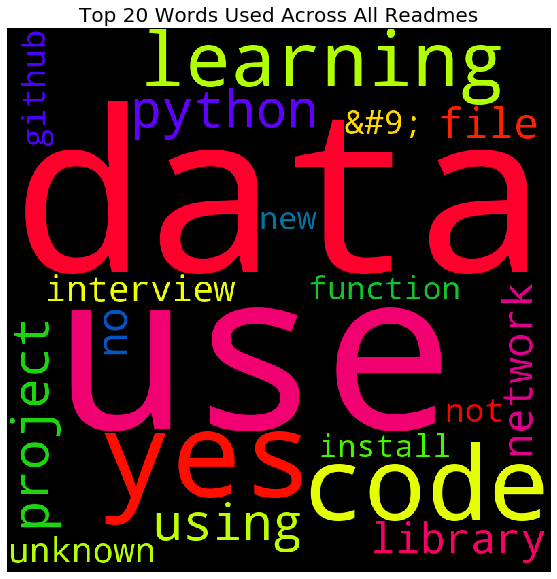

In [37]:
# Turn the dataframes into dictionaries
allz = {k: v for k, v in top_20_all_words.to_dict().items()}

# Use the dictionary objects and .generate_from_frequencies method of WordCloud 
# to generate a wordcloud map for each language
all_top_20_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(allz)

plt.figure(figsize=(10,10))
plt.title("Top 20 Words Used Across All Readmes", fontsize=20)
plt.imshow(all_top_20_cloud)
plt.axis('off')
plt.show()

### Visualization of top 20 words in all READMEs

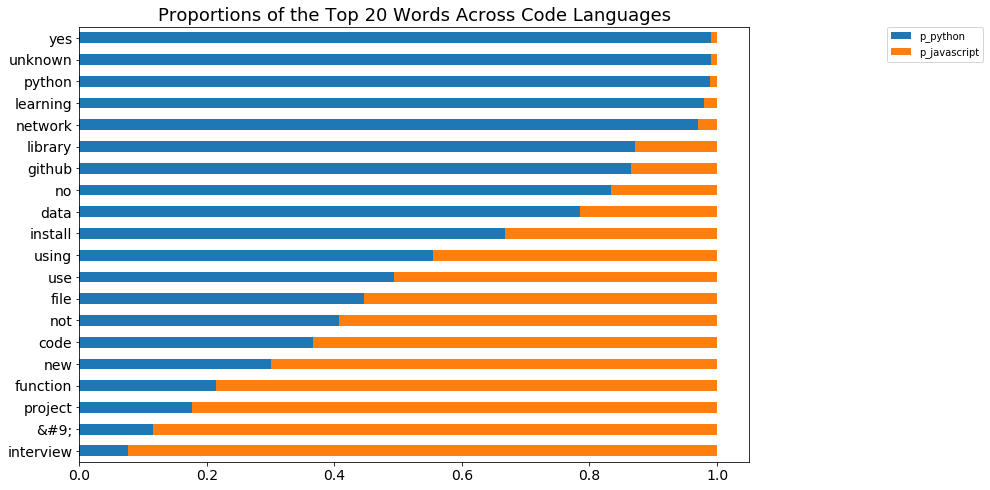

In [38]:
# visualize the percentage each coding language makes up for the top 20 words
(word_counts.assign(p_python = word_counts.python/word_counts['all'], 
                   p_javascript = word_counts.javascript/word_counts['all'])
 .sort_values(by='all')[['p_python', 'p_javascript']]
 .tail(20)
 .sort_values(by='p_python')
 .plot.barh(stacked=True, figsize=(12,8))
)
plt.title("Proportions of the Top 20 Words Across Code Languages", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.35, 1),borderaxespad=0)
plt.show()

## Top 10 Words from Javascript and Python

[Table of Content](#Table-of-Content)

### Word Cloud of top 10 words in Javascript and Python READMEs

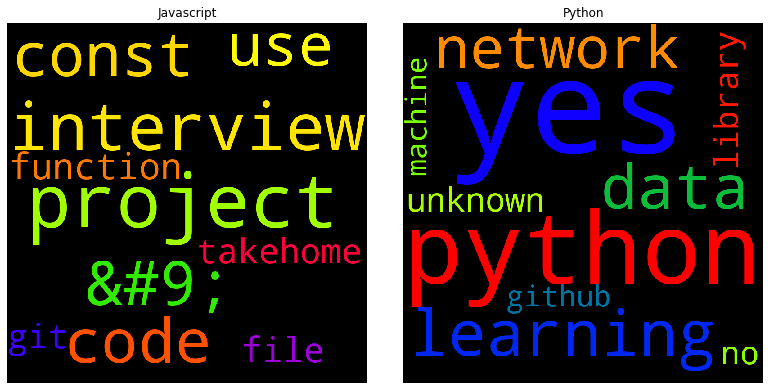

In [39]:
# Createa a top 10 words for each javascript and python
top_10_js_words = word_counts['javascript'].sort_values(ascending=False).head(10)
top_10_py_words = word_counts['python'].sort_values(ascending=False).head(10)

# Turn the dataframes into dictionaries
js = {k: v for k, v in top_10_js_words.to_dict().items()}
py = {k: v for k, v in top_10_py_words.to_dict().items()}


# Use the dictionary objects and .generate_from_frequencies method of WordCloud to generate a wordcloud map for each language
js10_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(js)

py10_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(py)

# Change the figure size
plt.figure(figsize=(10,10))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

# imshow => display data as an image
axs[0].imshow(js10_cloud)
axs[1].imshow(py10_cloud)

axs[0].set_title('Javascript')
axs[1].set_title('Python')

# Turn off the axis
for ax in axs: ax.axis('off')

### Word Cloud of top 10 words in Javascript and Python READMEs

<Figure size 1440x1008 with 0 Axes>

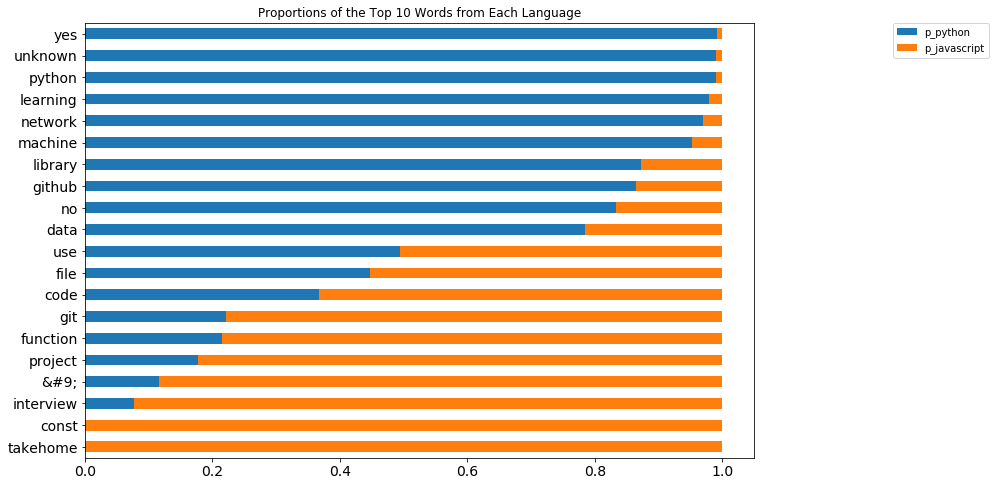

In [40]:
# visualize the percentage each coding language makes up for the top 10words of each programing language
plt.figure(figsize=(20,14))
(top10.assign(p_python = top10.python/top10['all'], 
                   p_javascript = top10.javascript/top10['all'])
 .sort_values(by='all')[['p_python', 'p_javascript']]
 .tail(20)
 .sort_values(by='p_python')
 .plot.barh(stacked=True, figsize=(12,8))
)

plt.title("Proportions of the Top 10 Words from Each Language")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.35, 1),borderaxespad=0)
plt.show()

## Creating column reflecting if README contains word from top 5 JavaScript words 

In [51]:
top_5_js_words = word_counts['javascript'].sort_values(ascending=False).head(5).index.tolist()


top_5_js_words

['project', 'interview', '&#9;', 'code', 'const']

In [53]:
contains = [train['readme'].str.contains(w) for w in top_5_js_words]

t5_js_index = train[np.any(contains, axis = 0)].index.tolist()

train['has_top_5_js_word'] = train.index.isin(t5_js_index)

train.head()

,language,readme,has_top_5_js_word
179,python,gensim topic modelling python gensim python li...,True
147,python,2020 mysql redis mongodb zookeeper nginx cpu 1...,True
168,python,labelimg labelimg graphical image annotation t...,True
225,python,wifiphisher rogue access point framework condu...,True
113,javascript,pjax pushstate ajax pjax jquery plugin us ajax...,True


# Model
[Table of Content](#Table-of-Content)

# Conclusion

[Table of Content](#Table-of-Content)